# Vulnerability Analysis and Defense Generation using AIShield SDK
* File Name: PyPi_Evasion_Reference_Implementation_MNIST
* Date of creation(dd-mm-yyyy) : 19-01-2023
* Author Name/Dept : AIShield
* Organization : BGSW
* Description : Source Code of reference implementation of AIShield API
* Copyright : Copyright 2022 Bosch Global Software Technologies Private Limited. All Rights Reserved.

### Input
This Example does the following:
* Downloads the MNIST-Dataset from Tensorflow-Datasets
* Trains a Tensorflow Model for Image Classification on the MNIST Dataset

### Output and Artifacts
1. Vulnerability report
2. Defense report
3. Defense model
4. attack samples

In [ ]:
<a target="_blank" href="https://colab.research.google.com/github/bosch-aisecurity-aishield/Reference-Implementations/blob/main/Product_Taskpair_wise/Image_Classification/Evasion/PyPi_Evasion_Reference_Implementation_MNIST.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [ ]:
# # Install AIShield SDK.
# # If not already installed, install by uncommenting the code below

# !pip install aishield

# 1.0 Install and Import Libraries


In [ ]:
"""
Description: commands to install all the packages, remove comments to install all the libraries. Generally not required for colab environmenty
Known issue: In colab, if get matplotlib error: cannot import name '_png' from 'matplotlib'. Use !pip install matplotlib==3.1.3
"""
# !pip install numpy==1.22
# !pip install matplotlib==3.3.4
# !pip install tensorflow==2.9.1
# !pip install scikit-learn==1.0.2
# !pip install humanfriendly==9.2
# !pip install tqdm==4.61.1
# !pip install requests==2.28.0
# !pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4


In [ ]:
"""
Description: Import libraries
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import zipfile 
import pandas as pd
import cv2
import os
import random
import requests
import json
import time
from tqdm import tqdm
import shutil
from humanfriendly import format_timespan
from datetime import datetime

#importing AIShield Library
import aishield as ais

# 2.0 Data Loading and Preprocessing

In [ ]:
'''
Description : Loading mnist dataset
'''
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data()

In [ ]:
'''
Description : Splitting data for validation
'''
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,stratify = y_train,test_size = 0.1,random_state = 42)

In [ ]:
'''
Description : Check size of dataset
'''
print("shape of x_train: ",X_train.shape)
print("shape of y_train: {}".format(y_train.shape))
print(f'shape of x_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')
print(f'shape of x_val: {X_val.shape}')
print(f'shape of y_val: {y_val.shape}')

shape of x_train:  (54000, 28, 28)
shape of y_train: (54000,)
shape of x_test: (10000, 28, 28)
shape of y_test: (10000,)
shape of x_val: (6000, 28, 28)
shape of y_val: (6000,)


In [ ]:
def plot(x, y=None, z=None, row: int = 2):
    """
    to visualize random sample
    """
    rows = row
    random_indices =  random.sample(range(x.shape[0]), rows * rows) #np.arange(rows*rows)#
    sample_images = x[random_indices, :]
    if y is not None:
        sample_labels = y[random_indices]
    if z is not None:
        attack_labels = z[random_indices]

    fig, axs = plt.subplots(nrows=rows, ncols=rows, figsize=(12, 9), sharex=True, sharey=True)
    for i in range(rows * rows):
        subplot_row = i // rows
        subplot_col = i % rows
        axs[subplot_row, subplot_col].imshow(sample_images[i, :])
        if y is not None:
            if z is not None:
                axs[subplot_row, subplot_col].set_title("Class. {}, image. {}".format(sample_labels[i], attack_labels[i]))
            else:
                axs[subplot_row, subplot_col].set_title("Class. {}".format(sample_labels[i]))
    plt.tight_layout()
    plt.show()

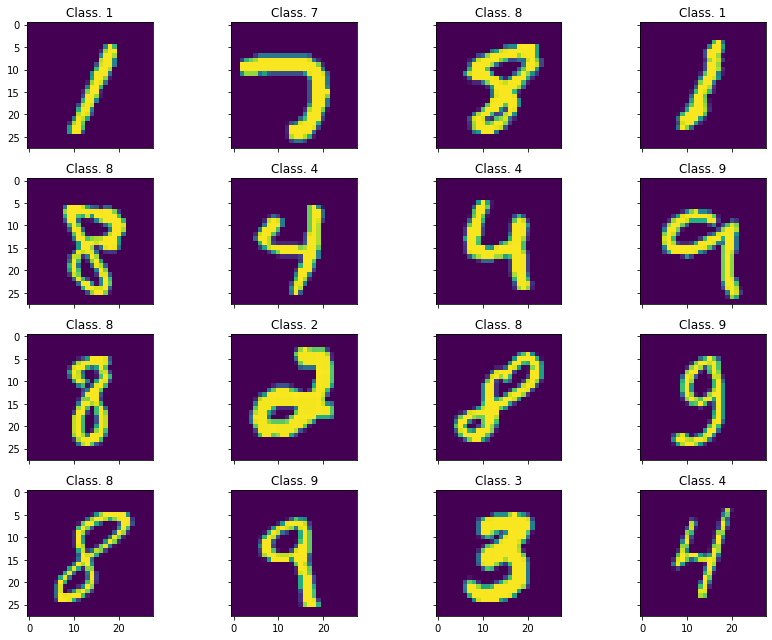

In [ ]:
"""
Description: visualize data
"""
plot(X_train, y_train, row=4)

In [ ]:
'''
Description : Set num_classes and input shape 
'''
img_row,img_col,channel=28,28,1
num_classes=10
input_shape=(img_row,img_col,channel)

In [ ]:
"""
Description: Normalizing and reshaping the data
"""
X_train = X_train.reshape(-1,*input_shape)/255.0
X_val =  X_val.reshape(-1,*input_shape)/255.0
X_test =  X_test.reshape(-1,*input_shape)/255.0

In [ ]:
"""
Description : Convert label to one hot encoder
"""
y_train=tf.keras.utils.to_categorical(y_train,num_classes)
y_test=tf.keras.utils.to_categorical(y_test,num_classes)

# 3.0 Model Development and Training

In [ ]:
def make_directory(directory):
    """
    create directory

    Parameters
    ----------
    directorys : list containing the directorys path to create 
    Returns
    -------
    None.

    """
    for d in directory:
        if os.path.isdir(d):
            print("directory {} already exist".format(d))
        if os.path.isdir(d)==False:
            os.mkdir(path=d)
            print("directory {} created successfully".format(d))

In [ ]:
def delete_directory(directorys):
    """
    delete directory 

    Parameters
    ----------
    directorys : list containing the directorys to deleate along with all the files

    Returns
    -------
    None.

    """
    if len(directorys)>=1:
        for d in directorys:
            if os.path.isdir(d):
                try:
                    if os.path.isfile(d):
                        os.remove(path=d)
                    else:
                        shutil.rmtree(path=d)
                        print("Removed: {}".format(d))
                except:
                    print("Failed to removed: {}".format(d))
                

In [ ]:
def make_archive(base_name,root_dir,zip_format='zip'):
    """
    created zip for given folder

    Parameters
    ----------
    base_name : name of zip file
    root_dir : directory to archive/zip
    zip_format : zip or tar 
        DESCRIPTION. The default is 'zip'.

    Returns
    -------
    None.

    """
    shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir)
    

In [ ]:
def get_file_path(path):
    """
    To get full file path from directory and child directory
    Args:
        path: Directory path

    Returns: list containing full path of all the file from the given directory

    """
    list_id = []
    for (root, dirs, files) in os.walk(path, topdown=True):
        if len(dirs) == 0:
            for file in files:
                list_id.append(os.path.join(root, file))
    return list_id

In [ ]:
"""
Description : Create data, model and label folder
"""
mnist_data_path = os.path.join(os.getcwd(), "data")
mnist_model_path = os.path.join(os.getcwd(), "model")
mnist_label_path = os.path.join(os.getcwd(), "label")
zip_path = os.path.join(os.getcwd(), "zip")
pyc_model_path = os.path.join(os.getcwd(), "pyc_model")
report_path = os.path.join(os.getcwd(), "reports")
sample_data = os.path.join(report_path, "sample_data")
defense_artifact = os.path.join(report_path, "defense_artifact")
# deleting folder
delete_directory(
    directorys=[mnist_data_path, mnist_model_path, mnist_label_path, zip_path, pyc_model_path, report_path])

# creating folder
make_directory([mnist_data_path, mnist_model_path, mnist_label_path, zip_path, pyc_model_path, report_path, sample_data,
                defense_artifact])

directory /content/data created successfully
directory /content/model created successfully
directory /content/label created successfully
directory /content/zip created successfully
directory /content/pyc_model created successfully
directory /content/reports created successfully
directory /content/reports/sample_data created successfully
directory /content/reports/defense_artifact created successfully


In [ ]:
def cnn_model(input_shape=input_shape, num_classes=num_classes):
    """
    Description: Create model architecture
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')  
    ])
    #Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss = 'categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
"""
Description: train model
"""
def train_model(model,X_train, y_train, X_test, y_test,batch_size=16,epochs=5,filename='mnist_model'):
    '''
    Description:Training  model
    Args:
        model:model to train 
        X_train: X_train for training 
        X_test: for validation
        y_train: label for X_train
        y_test: label for X_test
        batch_size: batch size for training model
        epochs: number of epochs to train model 
        filename : name to save extracted model
    '''    
    # Callbacks
    checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=filename+'.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
    ES=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,mode='min',restore_best_weights=True)
    
    #train and record time for training
    start_time=time.time()
    history=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1, callbacks=[ES,checkpoint],validation_data=(X_test,y_test))#tensorboard_callback,,validation_split=0.05
    elapsed_time = time.time() - start_time
    
    print("Elapsed time: {}".format(format_timespan(elapsed_time)))
    
    return model,history

In [ ]:
def Plot_model_training_parameters(training_history):
    """
    Description : plot model to visualize model training 
    
    Args:
        training_history: history from which model training parameter can be taken for plotting 
    """
    loss=training_history.history['loss']
    accuracy=training_history.history['accuracy']
    val_loss=training_history.history['val_loss']
    val_accuracy=training_history.history['val_accuracy']
    epochs_range=np.arange(1,len(loss)+1)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs_range,loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.title("Training loss ")
    plt.xlabel('Epochs',fontsize=16,fontweight='bold')
    plt.ylabel("Loss",fontsize=16,fontweight='bold')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs_range,accuracy,label="Training Accuracy")
    plt.plot(epochs_range,val_accuracy,label="Validation Accuracy")
    plt.title("Training accuracy")
    plt.xlabel('Epochs',fontsize=16,fontweight='bold')
    plt.ylabel("Accuracy",fontsize=16,fontweight='bold')
    plt.legend()
    plt.show()

In [ ]:
"""
Description : Created architecture of the model
"""
model=cnn_model()

In [ ]:
"""
Description : Get model summary
"""
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [ ]:
"""
Description: train model
"""
model,history=train_model(model,X_train, y_train, X_test, y_test,batch_size=32,epochs=1,filename=os.path.join(mnist_model_path,'mnist_model'))

1688/1688 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9692
Epoch 1: val_loss improved from inf to 0.04663, saving model to /content/model/mnist_model.h5
1688/1688 [==============================] - 488s 289ms/step - loss: 0.1061 - accuracy: 0.9692 - val_loss: 0.0466 - val_accuracy: 0.9845
Elapsed time: 8 minutes and 22.46 seconds


In [ ]:
"""
Description: Get prediction on validation data
"""
pred=model.predict(X_val)

188/188 [==============================] - 13s 68ms/step


In [ ]:
"""
Description: Convert prediction from probability to label
"""
y_pred = np.argmax(pred,axis=-1)
y_pred[:10]

array([1, 9, 3, 4, 6, 5, 0, 8, 5, 1])

In [ ]:
pred.shape

(6000, 10)

In [ ]:
"""
Description: Calculate Accuracy
"""
acc=metrics.accuracy_score(y_true=y_val,y_pred=y_pred)
print("Accuracy is : {:.03f}".format(acc))

Accuracy is : 0.983


In [ ]:
"""
Description: Calculate classification report
"""
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       592
           1       0.99      0.99      0.99       674
           2       0.98      1.00      0.99       596
           3       1.00      0.98      0.99       613
           4       0.97      1.00      0.98       584
           5       0.99      0.99      0.99       542
           6       0.99      0.97      0.98       592
           7       0.99      0.96      0.97       627
           8       0.97      0.99      0.98       585
           9       0.98      0.96      0.97       595

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



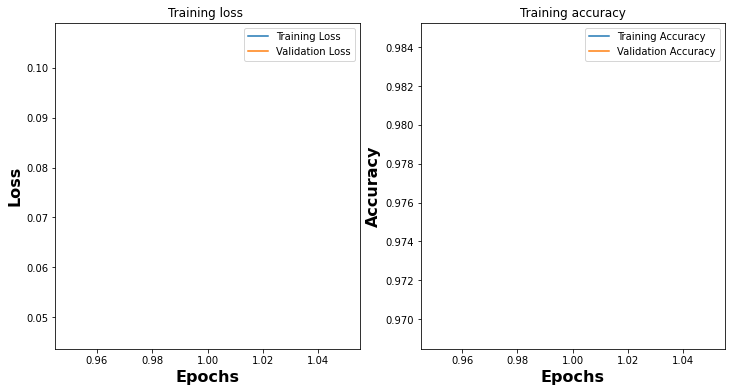

In [ ]:
"""
Description: Plot model learning 
"""
Plot_model_training_parameters(history)

# 4.0 Prepare Data , Model and Label

In [ ]:
def save_data_label(x, y, n, data_path=mnist_data_path, label_path = mnist_label_path):
    """
    x: data
    y: label
    n: number of sample to save
    data_path= path to save data
    label_path = path to save label path
    """
    if len(y.shape)==2:
        y = np.argmax(y, axis=-1)
 
    label=pd.DataFrame()
    img_name = []
    img_label = [] 

    for i in tqdm(range(n)):
        cv2.imwrite(os.path.join(data_path,str(i)+".jpg") ,x[i]*255.0) # don't use plt.imread otheriwse while loading the saved images , and passing to model there is accuarcy drop 
        img_name.append(str(i)+".jpg")
        img_label.append(y[i])
    label['image'] = img_name
    label["label"] = img_label

    # write orig_label dataframe
    label.to_csv(os.path.join(label_path,"label.csv"),index=False)

In [ ]:
"""
Description: save sample of data and label
"""
save_data_label(x = X_val, y= y_val, n=200, data_path=mnist_data_path, label_path = mnist_label_path)

100%|██████████| 200/200 [00:00<00:00, 5620.88it/s]


In [ ]:
"""
Description: Zip data
"""
make_archive(base_name=os.path.join(zip_path,"data"),root_dir=mnist_data_path,zip_format='zip')

In [ ]:
"""
Description: Zip label
"""
make_archive(base_name=os.path.join(zip_path,"label"),root_dir=mnist_label_path,zip_format='zip')

In [ ]:
"""
Description: save weight of model
"""
model.save_weights(os.path.join(pyc_model_path,"model_weight.h5"))

In [ ]:
python_code='''
#import library
import numpy as np
import tensorflow as tf

#define class
class BaseModel():
    """
    class for base model
    """
    def __init__(self,input_shape=(28,28,1),num_classes=10,model_weight_path="model_weight.h5"):
        """
        constructor for class

        Parameters
        ----------
        input_shape : TYPE, optional
            DESCRIPTION. The default is (28,28,1).
        num_classes : TYPE, optional
            DESCRIPTION. The default is 10.
        model_weight_path : string, optional
            DESCRIPTION. the relative path to model weight

        Returns
        -------
        None.

        """
        self.input_shape=input_shape
        self.num_classes=num_classes
        self.model_weight_path=model_weight_path
        

    def cnn_model(self,input_shape,num_classes):
        """
        model architecture

        Parameters
        ----------
        input_shape : string
            DESCRIPTION.input_shape for model e.g (28,28,1)
        num_classes : string
            DESCRIPTION.number of class e.g 10

        Returns
        -------
        model : model
            DESCRIPTION.

        """
        #create sequential model

        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(strides=(2,2)),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')   # used softmax , so set from_logits = False in cross entropy loss
        ])

        
        return model
    
    def predict(self,X):
        """
        predict for given data

        Parameters
        ----------
        X : numpy array 
            DESCRIPTION.

        Returns
        -------
        pred : numpy array
            DESCRIPTION.

        """
        model=self.cnn_model(input_shape=self.input_shape,num_classes=self.num_classes)
        model.load_weights(self.model_weight_path)
        
        pred=np.argmax(model.predict(X),axis=-1)
        return pred '''

In [ ]:
"""
Description: write model architecute to base_model.py file
"""
with open("base_model.py", "w") as file:
    file.writelines(python_code)

In [ ]:
"""
Description: function to create .pyc file
"""
import py_compile
py_compile.compile(file='base_model.py',cfile=os.path.join(pyc_model_path,'base_model.pyc'))

'/content/pyc_model/base_model.pyc'

* .pyc file with name base_model.pyc will get created
* delete .py file and still import and other function will work
* while AIShield API call , inplace of model.h5 file you can zip .pyc and model weight which will provide security to internal architecture

In [ ]:
"""
Description: check import from .pyc file
"""
from pyc_model.base_model import BaseModel
base_model=BaseModel(model_weight_path=r"pyc_model/model_weight.h5")

1/1 [==============================] - 0s 178ms/step
[1]


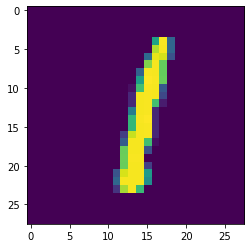

In [ ]:
"""
Description : getting prediction from function imported from .pyc file
"""
print(base_model.predict(X_val[:1]))
plt.imshow(X_val[0])

In [ ]:
"""
Description: Zip model
"""
model_encryption=0 #  0 if model is uploaded directly as a zip, 1 if model is encryted as .pyc and uploaded as a zip
if os.path.isfile(os.path.join(zip_path,"model.zip")):
    delete_directory(directorys=[os.path.join(zip_path,"model.zip")])
if model_encryption:
    make_archive(base_name=os.path.join(zip_path,"model"),root_dir=pyc_model_path,zip_format='zip')
else:
    make_archive(base_name=os.path.join(zip_path,"model"),root_dir=mnist_model_path,zip_format='zip')

# 5.0 Vulnerability Analysis and Defense Generation using AIShield SDK

In [ ]:
"""
Description: AIShield API URL and subscription key
""" 
baseurl="XXXXXXXXXXXXXXXXXXXXXXXXXXX" # fill in API endpoint url from AIShield developer portal under API tab 
url=baseurl+"/api/ais/v1.5"
api_key = "xxxxxxxxxx" # fill in subscription key from AIShield developer portal under My Dashboard tab
org_id = "xxxxxxxxxxxx" # fill in Org_Id provided in welcome email

In [ ]:
"""
Description: File paths
"""
data_path=os.path.join(zip_path,'data.zip') #full path of data zip
label_path=os.path.join(zip_path,'label.zip') #full path of label zip
model_path=os.path.join(zip_path,'model.zip') #full path of model zip

### `Perform Vulnerability Analysis through VulConfig Function`

In [ ]:
"""
Description: Initialize the AIShield API
"""
client = ais.AIShieldApi(api_url=url, api_key=api_key, org_id=org_id)

In [ ]:
"""
Description: Define the task and analysis type
"""
task_type = ais.get_type("task", "image_classification")
analysis_type = ais.get_type("analysis", "evasion")

In [ ]:
"""
Description: Perform model registration and upload the input artifacts
"""
status, job_details = client.register_model(task_type=task_type, analysis_type=analysis_type)
model_id = job_details.model_id
# print('Model id: {} \nInput artifacts will be uploaded as:\n data_upload_uri: {}\n label_upload_uri: {}'
#       '\n model_upload_uri: {}'.format(model_id, job_details.data_upload_uri, job_details.label_upload_uri,
#                                        job_details.model_upload_uri))

upload_status = client.upload_input_artifacts(job_details=job_details,
                                              data_path=data_path,
                                              label_path=label_path,
                                              model_path=model_path, )
print('Upload status: {}'.format(', '.join(upload_status)))

Upload status: data file upload successful, label file upload successful, model file upload successful


In [ ]:
"""
Description: Specify the appropriate configs required for vulnerability analysis
"""

vuln_config = ais.VulnConfig(task_type=task_type,
                             analysis_type=analysis_type,
                             defense_generate=True)

vuln_config.input_dimensions = input_shape  # input dimension for mnist digit classification
vuln_config.number_of_classes = num_classes  # number of classes for mnist digit classification
vuln_config.encryption_strategy = 0  # value 0 (or) 1, if model is unencrypted or encrypted(pyc) respectively
print('IC-Extraction parameters are: \n {} '.format(vuln_config.get_all_params()))

IC-Extraction parameters are: 
 {'defense_bestonly': 'no', 'encryption_strategy': 0, 'input_dimensions': '(28, 28, 1)', 'model_api_details': '', 'model_framework': 'tensorflow', 'normalize_data': 'yes', 'number_of_classes': 10, 'use_model_api': 'no', 'vulnerability_threshold': 0} 


In [ ]:
"""
Description: Run vulnerability analysis
"""
my_status, job_details = client.vuln_analysis(model_id=model_id, vuln_config=vuln_config)
my_job_id = job_details.job_id
print('status: {} \nJob_id: {} '.format(my_status, my_job_id))

status: success 
Job_id: gAAAAABj4Kc2TA2g1HvJVtyfjgd6hdjEm6zmA_7aoytnvqCXk-_5c4pfDT7Gh9npeUA8fzMFhdiiimqAoMHBza5S_D3eLPsEMA== 


In [ ]:
"""
Description: Monitor progress for given Job ID using the Link below
"""
print('Click on the URL to view Vulnerability Dashboard (GUI): {}'.format(job_details.job_monitor_uri))

Click on the URL to view Vulnerability Dashboard (GUI): https://xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx==


In [ ]:
"""
Description: Fetch Job status using Job ID
"""
my_status = client.job_status (job_id = my_job_id)
print('job status ', my_status)

2023-02-06 07:07:34,860 - INFO - Fetching job details for job id xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx==
INFO:aishield.connection:Fetching job details for job id xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx==
2023-02-06 07:07:41,067 - INFO - ModelExploration_Status:inprogress
INFO:aishield.connection:ModelExploration_Status:inprogress


2023-02-06 07:07:59,710 - INFO - ModelExploration_Status:completed
INFO:aishield.connection:ModelExploration_Status:completed
2023-02-06 07:07:59,716 - INFO - SanityCheck_Status:passed
INFO:aishield.connection:SanityCheck_Status:passed
2023-02-06 07:07:59,720 - INFO - EvasionAnalysis_Status:inprogress
INFO:aishield.connection:EvasionAnalysis_Status:inprogress


2023-02-06 07:17:50,914 - INFO - EvasionAnalysis_Status:completed
INFO:aishield.connection:EvasionAnalysis_Status:completed
2023-02-06 07:17:50,920 - INFO - DefenseReport_Status:inprogress
INFO:aishield.connection:DefenseReport_Status:inprogress


2023-02-06 07:19:36,820 - INFO - DefenseReport_Status:completed
INFO:aishield.connection:DefenseReport_Status:completed
2023-02-06 07:19:36,824 - INFO - Analysis completed for job id xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx==
INFO:aishield.connection:Analysis completed for job id xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx==


job run completed
job status  success


### `Saving the Artifacts and the Reports`

In [ ]:
"""
Description: Creating a directory to save the defense artifacts
"""
OUTPUT_PATH = os.path.join(os.getcwd(),"Output_Artifacts")
make_directory([OUTPUT_PATH])

directory /content/Output_Artifacts already exist


In [ ]:
"""
Description: Download the Vulnerability Report
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "vulnerability"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

2023-02-06 07:19:36,864 - INFO - directory /content/Output_Artifacts already exist
INFO:aishield.utils.util:directory /content/Output_Artifacts already exist
2023-02-06 07:19:39,359 - INFO - vulnerability_20230206_0719.pdf is saved in /content/Output_Artifacts
INFO:aishield.connection:vulnerability_20230206_0719.pdf is saved in /content/Output_Artifacts


In [ ]:
"""
Description: Download the Defense Reports
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "defense"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

2023-02-06 08:23:01,633 - INFO - directory /content/Output_Artifacts already exist
INFO:aishield.utils.util:directory /content/Output_Artifacts already exist
2023-02-06 08:23:04,272 - INFO - defense_20230206_0823.pdf is saved in /content/Output_Artifacts
INFO:aishield.connection:defense_20230206_0823.pdf is saved in /content/Output_Artifacts


In [ ]:
"""
Description: Download the Defense artifacts: Model
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "defense_artifact"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

2023-02-06 08:23:17,897 - INFO - directory /content/Output_Artifacts already exist
INFO:aishield.utils.util:directory /content/Output_Artifacts already exist
2023-02-06 08:23:20,129 - INFO - defense_artifact_20230206_0823.zip is saved in /content/Output_Artifacts
INFO:aishield.connection:defense_artifact_20230206_0823.zip is saved in /content/Output_Artifacts


In [ ]:
"""
Description: Download the Attack Samples
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "attack_samples"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

2023-02-06 08:23:20,851 - INFO - directory /content/Output_Artifacts already exist
INFO:aishield.utils.util:directory /content/Output_Artifacts already exist
2023-02-06 08:23:22,712 - INFO - attack_samples_20230206_0823.zip is saved in /content/Output_Artifacts
INFO:aishield.connection:attack_samples_20230206_0823.zip is saved in /content/Output_Artifacts


## Experimentation Report